# Bayesian analysis of the empirical saturation point (refactored version)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

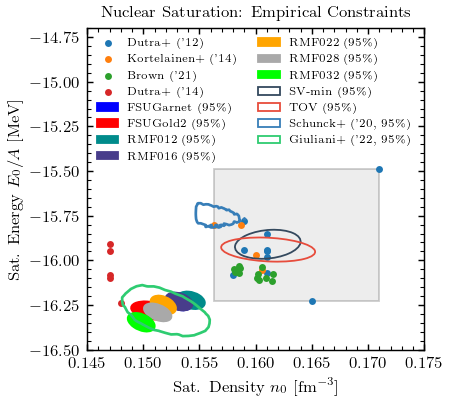

In [2]:
from modules.SaturationAnalysis import SaturationAnalysis
analysis = SaturationAnalysis()
analysis.plot_constraints(eft=False, eft_conf_level=0.95)

## Priors

Let's take a look at the priors used in this work. They can be specified in the file `modules/priors.py`.

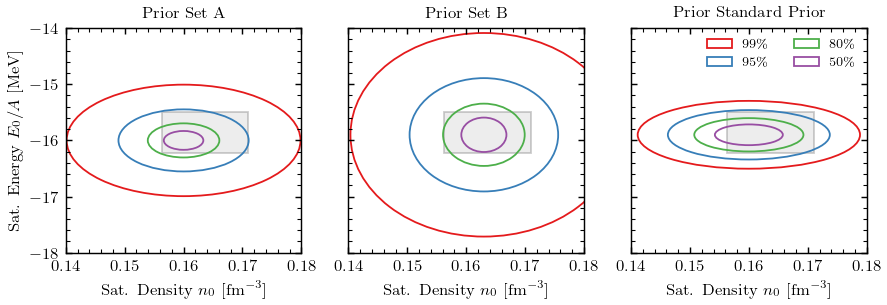

In [3]:
from modules.SaturationAnalysis import visualize_priors
from modules.priors import *
fig, axs = visualize_priors(used_prior_sets)
fig.savefig("pdf/prior_sets.pdf")

We use an uninformed prior (left) and an informed prior (right) and something in between (center panel) to investigate the prior sensitivity of our Bayesian inference.

## Saturation box in Drischler et al. (2016)
### Apply our statistical model directly

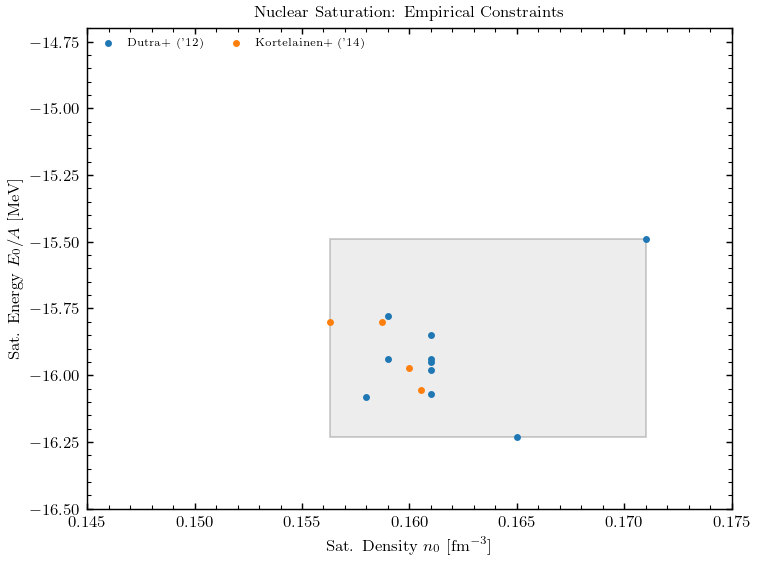

In [4]:
from modules.SaturationAnalysis import drischler_satbox
drischler_satbox.plot(plot_box_estimate=True)

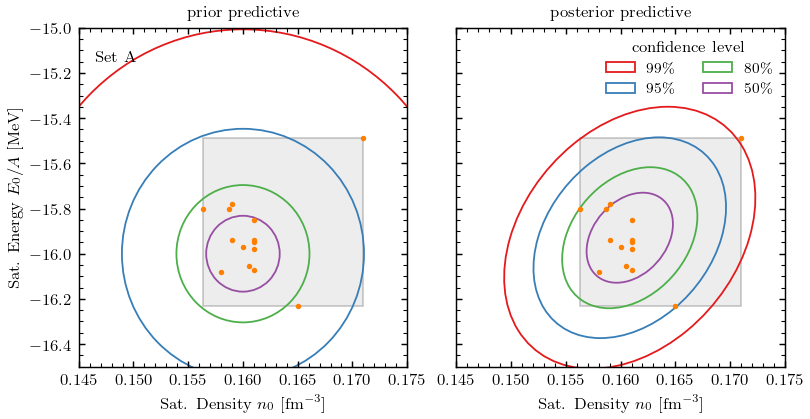

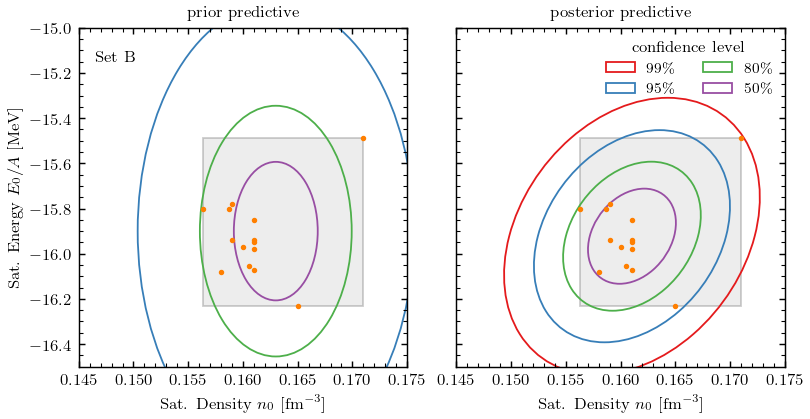

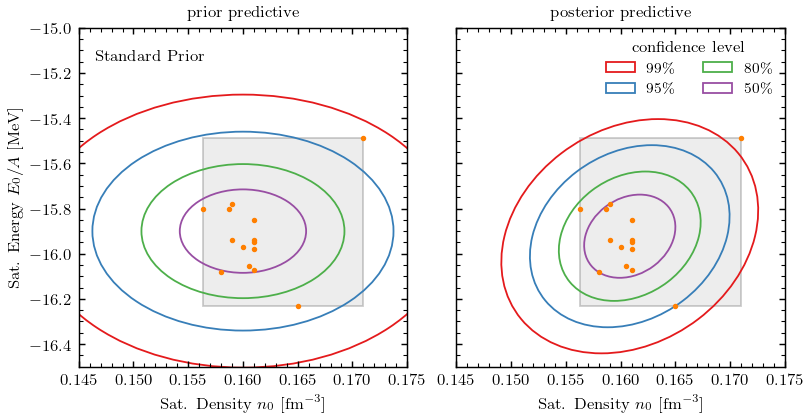

In [5]:
from modules.StatisticalModel import StatisticalModel
for prior_set in used_prior_sets:
    model = StatisticalModel(data=drischler_satbox.data_frame, prior_params=prior_set)
    fig, _ = model.plot_predictives(validate=False)
    fig.savefig(f"overview_analysis_satbox_{label_filename(prior_set['label'])}.pdf")

Set A {'kappa': 15, 'nu': 18, 'mu': array([  0.16083667, -15.9292    ]), 'Psi': array([[1.71660933e-04, 2.63578000e-03],
       [2.63578000e-03, 4.38030400e-01]])}
Set B {'kappa': 15, 'nu': 18, 'mu': array([  0.16103667, -15.92253333]), 'Psi': array([[1.77940933e-04, 2.61971333e-03],
       [2.61971333e-03, 4.89203733e-01]])}
Standard Prior {'kappa': 15, 'nu': 24, 'mu': array([  0.16083667, -15.92253333]), 'Psi': array([[2.62060933e-04, 2.55211333e-03],
       [2.55211333e-03, 5.11603733e-01]])}


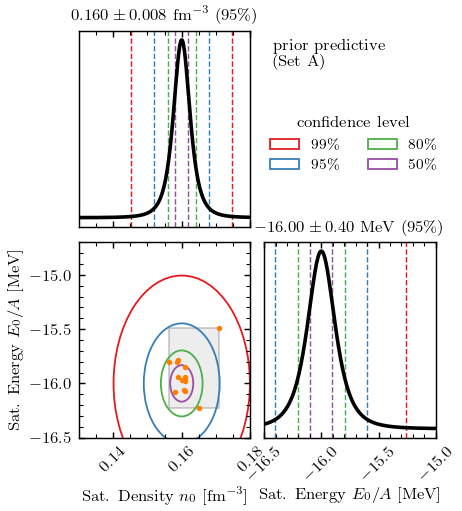

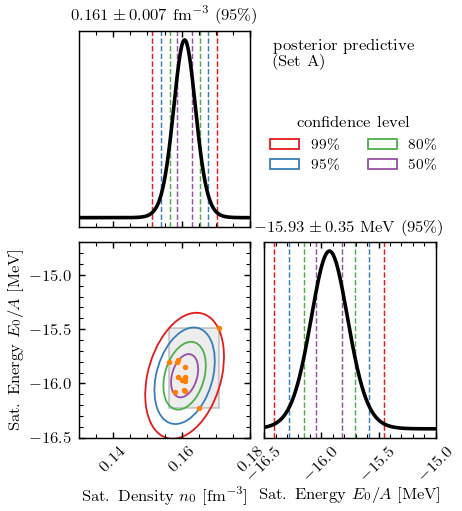

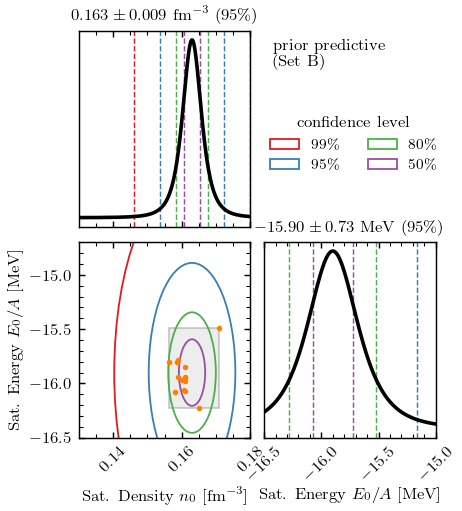

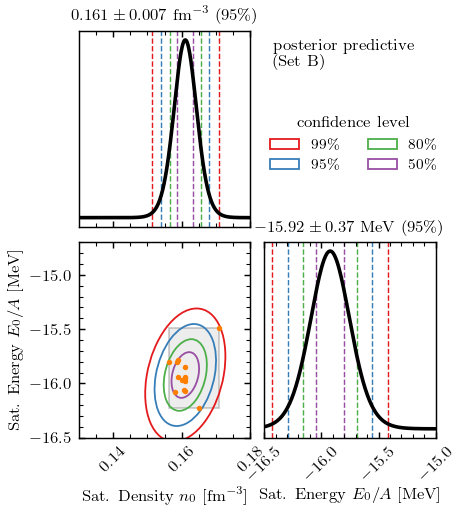

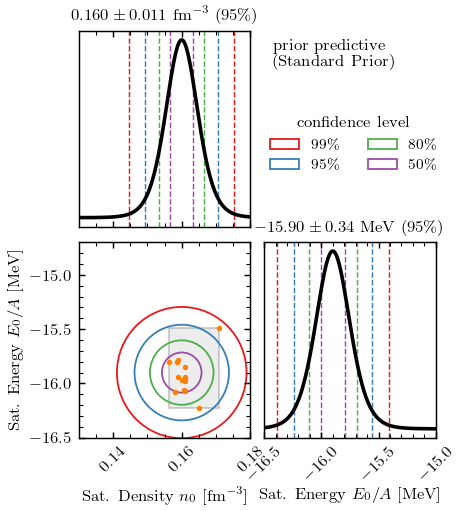

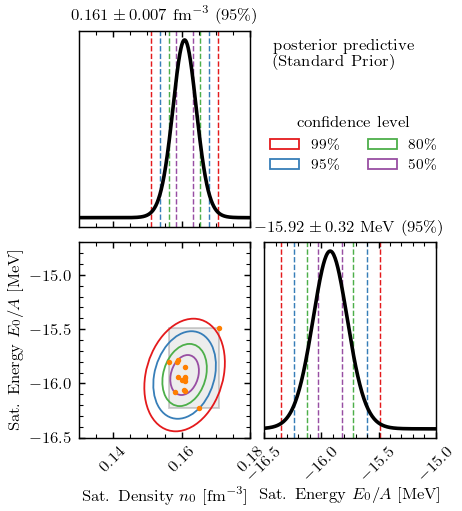

In [6]:
import matplotlib.backends.backend_pdf
for prior_set in used_prior_sets:
    model = StatisticalModel(data=drischler_satbox.data_frame, prior_params=prior_set)
    ret = model.plot_predictives_corner()
    pdf = matplotlib.backends.backend_pdf.PdfPages(f"pdf/corner_plot_{label_filename(prior_set['label'])}.pdf")
    print(prior_set['label'], model.posterior_params)
    for elem in ret:
        fig, axs = elem
        pdf.savefig(fig)
    pdf.close()

Generating the corner plot did not require any sampling of the distribution functions. Only (semi-)analytic calculations. Let's check our implementation brute-force using sampling:

Set A {'kappa': 15, 'nu': 18, 'mu': array([  0.16083667, -15.9292    ]), 'Psi': array([[1.71660933e-04, 2.63578000e-03],
       [2.63578000e-03, 4.38030400e-01]])}
Set B {'kappa': 15, 'nu': 18, 'mu': array([  0.16103667, -15.92253333]), 'Psi': array([[1.77940933e-04, 2.61971333e-03],
       [2.61971333e-03, 4.89203733e-01]])}
Standard Prior {'kappa': 15, 'nu': 24, 'mu': array([  0.16083667, -15.92253333]), 'Psi': array([[2.62060933e-04, 2.55211333e-03],
       [2.55211333e-03, 5.11603733e-01]])}


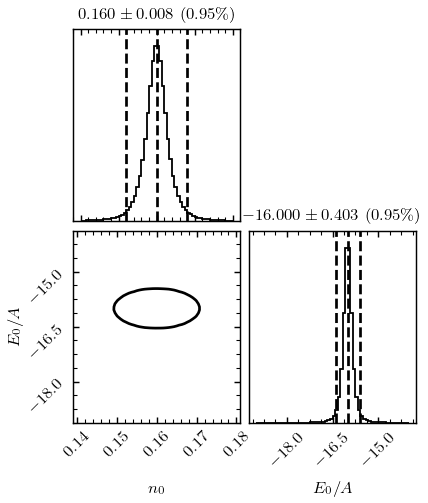

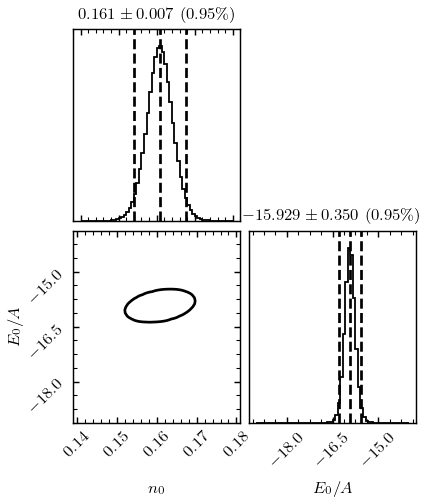

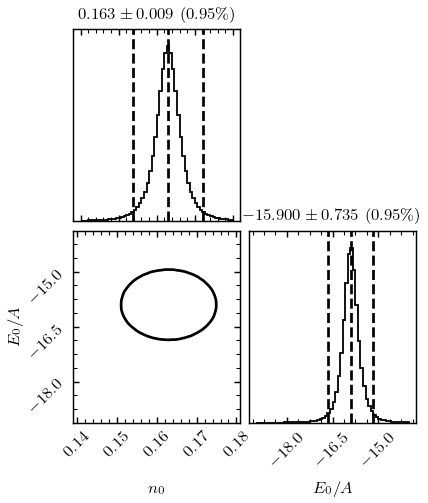

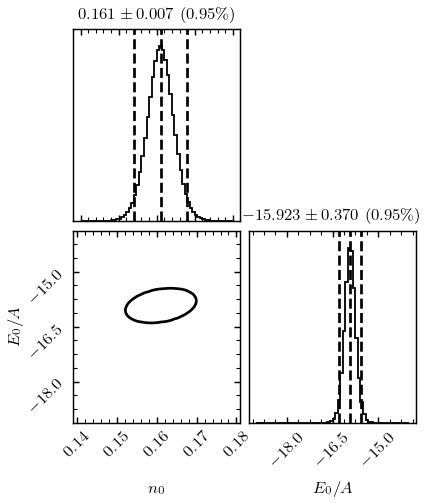

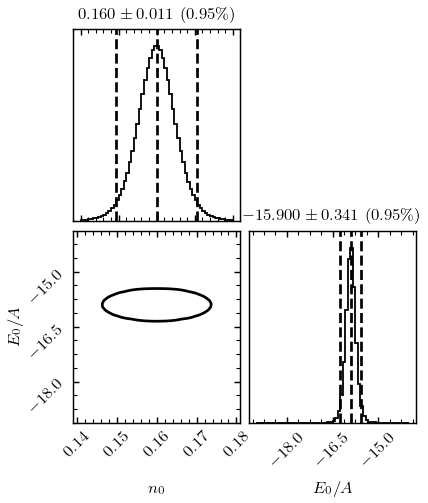

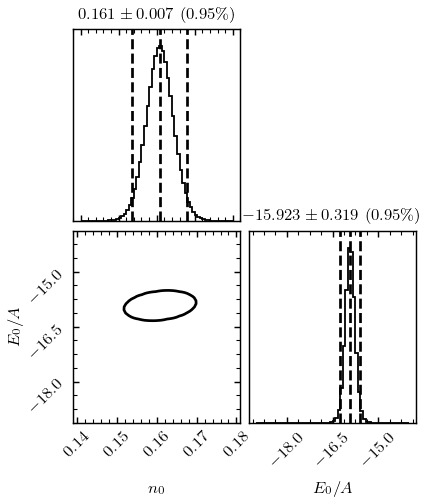

In [7]:
import matplotlib.backends.backend_pdf
for prior_set in used_prior_sets:
    model = StatisticalModel(data=drischler_satbox.data_frame, prior_params=prior_set)
    ret = model.plot_predictives_corner_bf()
    pdf = matplotlib.backends.backend_pdf.PdfPages(f"pdf/corner_plot_bf_{label_filename(prior_set['label'])}.pdf")
    print(prior_set['label'], model.posterior_params)
    for elem in ret:
        fig, axs = elem
        pdf.savefig(fig)
    pdf.close()

The results match. However, the Python package `corner` has a known bug. The percentiles in the titles are always the default ones. We have fixed the issue by computing the percentiles separately. The percentiles above correspond to the 95% confidence level.

### Alternative: use a single Monte Carlo step

MC sampling: 100%|██████████| 1/1 [03:25<00:00, 205.34s/it]


Results written to './pdf/drischler-satbox_set_a_10000000_1.pdf'
Set A {'mu': array([  0.16083726, -15.9291814 ]), 'Psi': array([[1.07732938e-05, 1.65442829e-04],
       [1.65442829e-04, 2.74778548e-02]]), 'df': 17.0}


MC sampling: 100%|██████████| 1/1 [03:22<00:00, 202.42s/it]


Results written to './pdf/drischler-satbox_set_b_10000000_1.pdf'
Set B {'mu': array([  0.16103749, -15.92244686]), 'Psi': array([[1.11735704e-05, 1.64430198e-04],
       [1.64430198e-04, 3.07232501e-02]]), 'df': 17.0}


MC sampling: 100%|██████████| 1/1 [03:18<00:00, 198.67s/it]


Results written to './pdf/drischler-satbox_standard_prior_10000000_1.pdf'
Standard Prior {'mu': array([  0.16083546, -15.92255027]), 'Psi': array([[1.21499924e-05, 1.18545754e-04],
       [1.18545754e-04, 2.37251171e-02]]), 'df': 23.0}


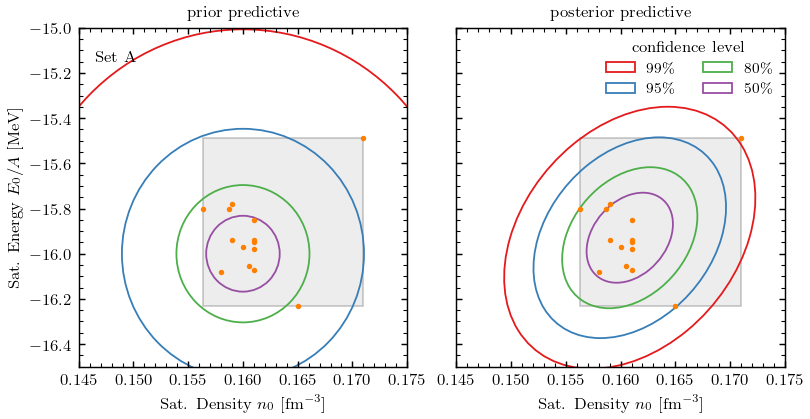

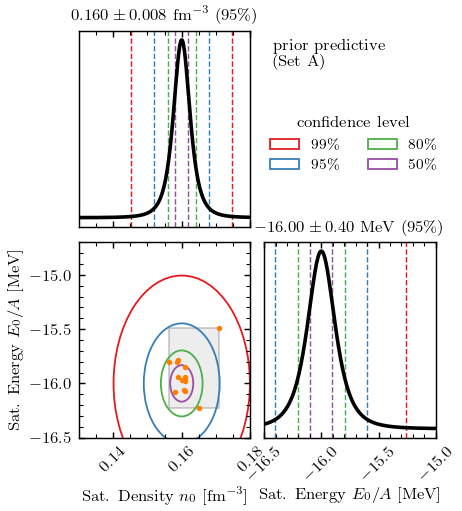

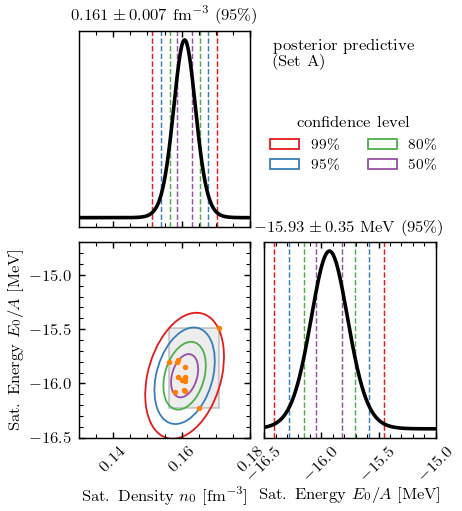

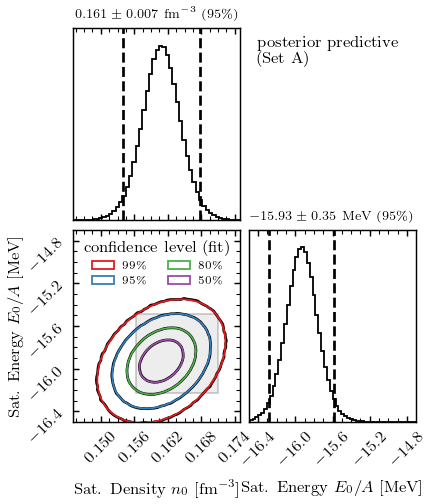

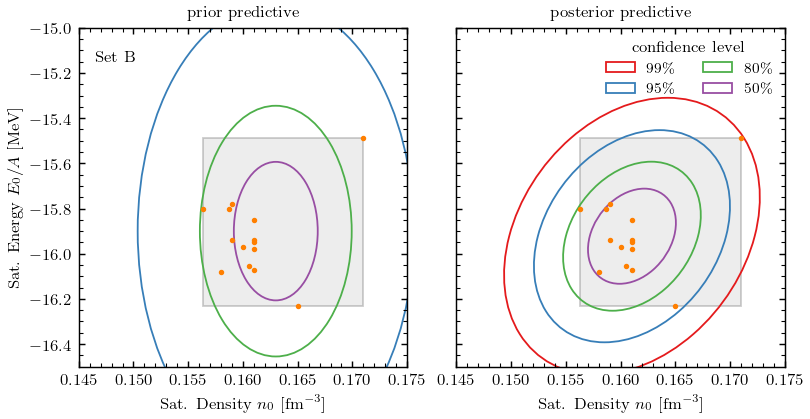

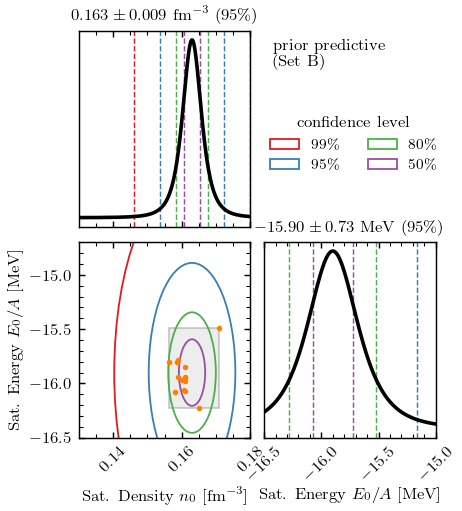

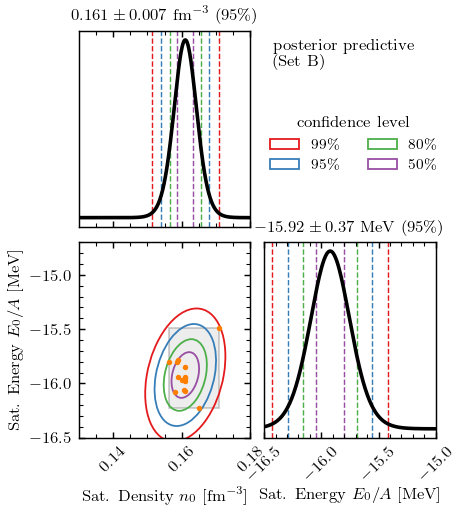

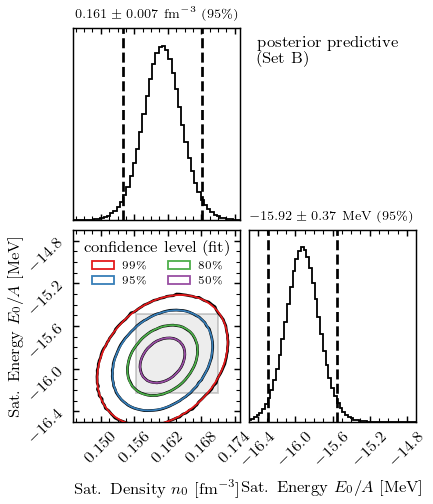

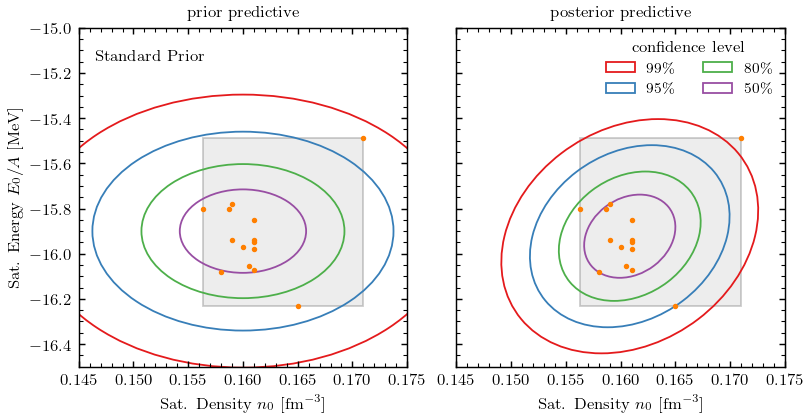

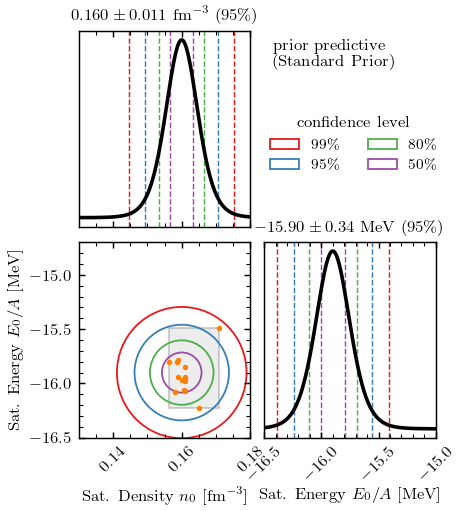

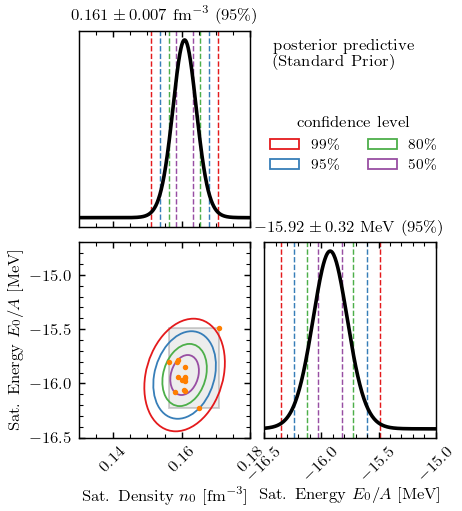

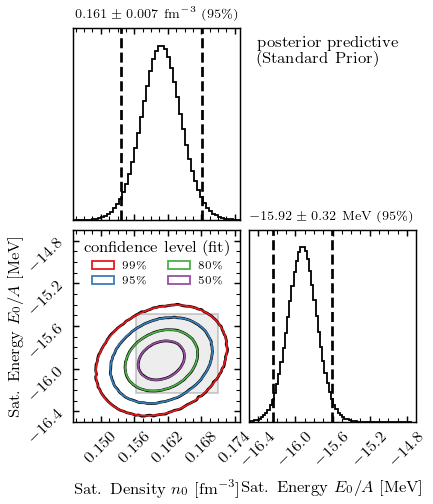

In [8]:
from modules.DataSets import DataSetSampleConfig, Scenario
from modules.SaturationAnalysis import drischler_satbox

config = DataSetSampleConfig(data_set=drischler_satbox)
config.sample_kwargs["num_points"] = None  # use all points for the analysis
scenarioX = Scenario(
    label="Drischler Satbox",
    configs=[config]
)

for prior_set in used_prior_sets:
    fit = analysis.multiverse(
            scenarioX,
            num_realizations=1,
            prior_params=prior_set,
            debug=False,
            plot_fitted_conf_regions=True
    )
    print(prior_set["label"], fit)

## Hierarchical model

In [9]:
from modules.DataSets import DataSetSampleConfig, Scenario
from modules.SaturationAnalysis import DEFAULT_DFT_CONSTRAINTS as dft_constraints
scenario1 = Scenario(
    label="FSU-only",
    configs=[DataSetSampleConfig(data_set=dft_constraints["FSU"])]
)

scenario2 = Scenario(
    label="FSU+Schunck-only",
    configs=[
        DataSetSampleConfig(
            data_set=dft_constraints["FSU"]
        ),
        DataSetSampleConfig(
            data_set=dft_constraints["Schunck"]
        )
    ]
)
scenario3 = Scenario(
    label="all-but-FSU",
    configs=[
        DataSetSampleConfig(
            data_set=dft_constraints[lbl]
        ) for lbl in dft_constraints.keys() if lbl != "FSU"
    ]
)
scenario4 = Scenario(
    label="Giuliani+Schunck-only",
    configs=[DataSetSampleConfig(
        data_set=dft_constraints["Giuliani"]
    ),
        DataSetSampleConfig(
            data_set=dft_constraints["Schunck"]
        )
    ]
)
# scenario1.configs[0].data_set.plot()

In [10]:
for prior_set in used_prior_sets:
    fit = analysis.multiverse(scenario3, num_realizations=1000,
                            num_samples_mu_Sigma=10000,
                            prior_params=prior_set)
    print(prior_set["label"], fit)
    # analysis.plot_individual_models()

MC sampling: 100%|██████████| 1000/1000 [15:47<00:00,  1.06it/s]


Results written to './pdf/all-but-fsu_set_a_10000_1000.pdf'
Set A {'mu': array([  0.15752181, -15.9827087 ]), 'Psi': array([[2.19001424e-05, 2.68813644e-04],
       [2.68813644e-04, 2.54420944e-02]]), 'df': 9.0}


MC sampling: 100%|██████████| 1000/1000 [20:35<00:00,  1.24s/it]


Results written to './pdf/all-but-fsu_set_b_10000_1000.pdf'
Set B {'mu': array([  0.15790193, -15.97057344]), 'Psi': array([[2.51587801e-05, 3.28306738e-04],
       [3.28306738e-04, 3.23139218e-02]]), 'df': 9.0}


MC sampling: 100%|██████████| 1000/1000 [23:36<00:00,  1.42s/it]


Results written to './pdf/all-but-fsu_standard_prior_10000_1000.pdf'
Standard Prior {'mu': array([  0.15753623, -15.97108293]), 'Psi': array([[2.04410205e-05, 1.84178297e-04],
       [1.84178297e-04, 2.22389656e-02]]), 'df': 14.0}


## EFT predictions for the nuclear saturation point

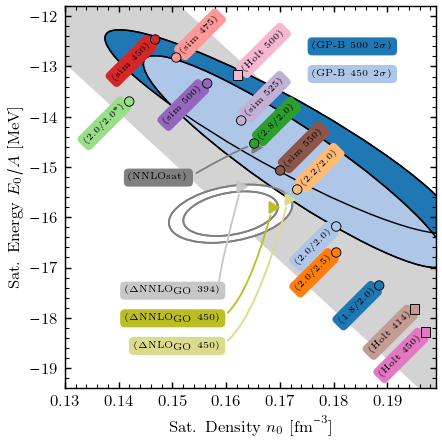

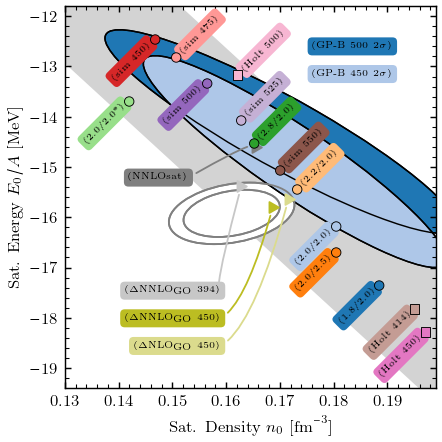

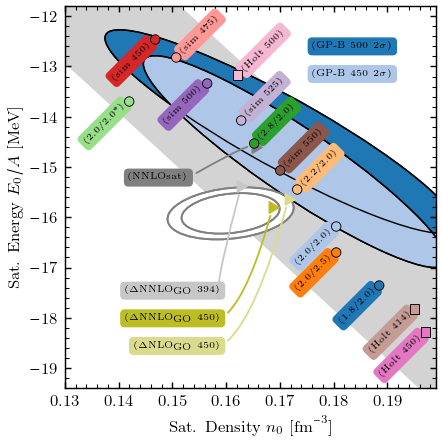

In [11]:
from modules.plot_helpers import cm
import matplotlib.pyplot as plt
from modules.eft_satpoints import make_coester_plot
for prior_set in used_prior_sets:
    fig, ax = plt.subplots(1, 1, figsize=(8.6*cm, 8.6*cm), constrained_layout=True)
    model = StatisticalModel(data=drischler_satbox.data_frame, prior_params=prior_set)
    make_coester_plot(ax,
                      #emp_constraint=drischler_satbox.box_estimate().update({"type": "box"})
                      emp_constraint={"type": "t", **model.predictives_params(return_dict=True)}
                      )
    fig.savefig(f"pdf/eft_satpoints_{label_filename(prior_set['label'])}.pdf")

## Symmetry energy at saturation density

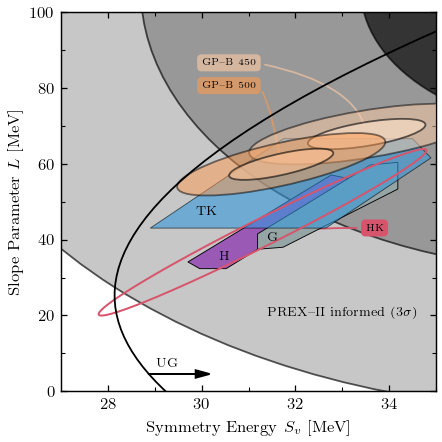

In [12]:
from modules.plot_helpers import cm
from modules.symmetry_energy import make_sv_l_plot
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(8.6*cm, 8.6*cm), constrained_layout=True)
make_sv_l_plot(axs)
fig.savefig("pdf/esym.pdf")